# Product Recommender System Using OpenAI API

Author: Stefanie Warum

In [1]:
import os
from openai import OpenAI
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial import distance
from adjustText import adjust_text

# Define the model to use
model = "gpt-4-turbo"
client = OpenAI(api_key=os.environ["OPENAI"])

In [2]:
# Import file with products
from products import products # List of all products

In [3]:
# Example products
for product in products[:5]:
    print(f"{product['title']}: {product['price']}")

Ski Pass Alpine Valley: 65.0
Beginner Ski Lessons: 120.0
High-Performance Ski Set Rental: 35.0
Snow Festival Ticket: 45.0
Mountain Top Dining Experience: 150.0


## Create embeddings for product descriptions

In [13]:
# Extract a list of product short descriptions from products
product_descriptions = [product["short_description"] for product in products]

# Create embeddings for each product description
response = client.embeddings.create(
    model="text-embedding-ada-002",
    input=product_descriptions
)

response_dict = response.model_dump()

# Extract the embeddings from response_dict and store in products
for i, product in enumerate(products):
    product['embedding'] = response_dict["data"][i]["embedding"]

# Extract the embeddings from response_dict and store in products
for i, product in enumerate(products):
    product['embedding'] = response_dict["data"][i]["embedding"]
    
print(products[0].items())

dict_items([('title', 'Ski Pass Alpine Valley'), ('short_description', 'Full-day lift pass for Alpine Valley Resort, granting access to all slopes.'), ('price', 65.0), ('category', 'Ski Pass'), ('features', ['Unlimited lifts', 'Access from 9 AM to 5 PM', 'Includes night skiing on select days']), ('embedding', [0.001773689640685916, 0.014779654331505299, 0.02460215613245964, -0.037270430475473404, -0.026556165888905525, 0.020654795691370964, -0.022333407774567604, -0.034201718866825104, -0.002244160044938326, -0.022962886840105057, 0.003967032302170992, 0.008845498785376549, 0.001619598246179521, -0.029139654710888863, -0.01018969900906086, -0.01736314222216606, 0.010615909472107887, -0.026936477050185204, 0.006648877169936895, 0.008379945531487465, 0.011074905283749104, -0.006202995777130127, 0.0005975137464702129, -0.010596238076686859, -0.010386412031948566, 0.017664767801761627, 0.005032557528465986, -0.004927644040435553, 0.020392512902617455, -0.0210744496434927, 0.035172168165445

## Visualizing the embedded descriptions

Use t-SNE for dimensionality reduction and reducing the embeddings data from 1536 to e.g. 2, which will make the data more easily to visualize.

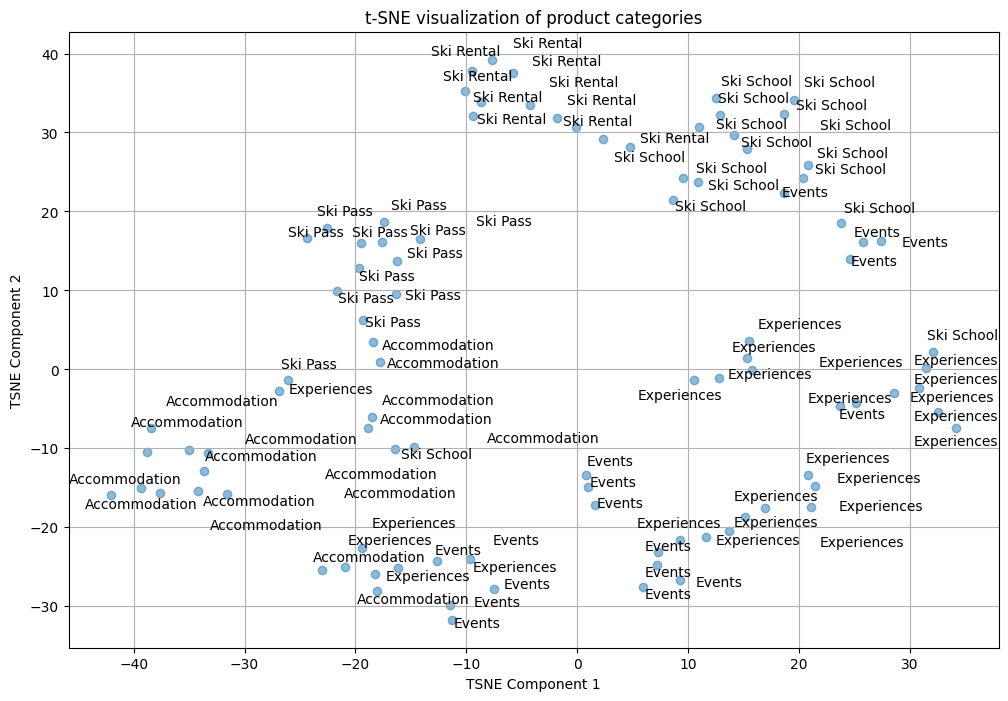

In [5]:
categories = [product['category'] for product in products]
embeddings = [product['embedding'] for product in products]

# Reduce the number of embeddings dimensions to two using t-SNE
tsne = TSNE(n_components=2, perplexity=5)
embeddings_2d = tsne.fit_transform(np.array(embeddings))

plt.figure(figsize=(12, 8)) # Create a larger plot to help with readability
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5) # Create a scatter plot from embeddings_2d

# Add annotations and use adjust_text to avoid overlap
texts = []
for i, category in enumerate(categories):
    texts.append(plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], category))

# Automatically adjust text positions
adjust_text(texts)

# Add grid and labels for clarity
plt.grid(True)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('t-SNE visualization of product categories')

plt.show()

## Custom functions for embeddings and distances



This function, find_n_closest, takes a query vector, a list of embeddings, and an optional parameter n indicating the number of closest embeddings to find (default is 3).

For each embedding in the list, it calculates the cosine distance between the query vector and the embedding. It then stores these distances along with their corresponding index in a list of dictionaries called distances.

After computing all distances, it sorts the distances list based on the distance values in ascending order using the sorted function with a lambda function as the key to sort by the "distance" key in each dictionary.

Finally, it returns the first n elements of the sorted distances list, representing the n closest embeddings to the query vector, along with their corresponding distances and indices.

Test the function for a search text "skirental" to retrieve closest entries in products.

In [6]:
def find_n_closest(query_vector, embeddings, n=3):
  distances = []
  for index, embedding in enumerate(embeddings):
    # Calculate the cosine distance between the query vector and embedding
    dist = distance.cosine(query_vector, embedding)
    # Append the distance and index to distances
    distances.append({"distance": dist, "index": index})
  # Sort distances by the distance key
  distances_sorted = sorted(distances, key=lambda x: x["distance"])
  # Return the first n elements in distances_sorted
  return distances_sorted[0:n]

In [7]:
# Define a create_embeddings function
def create_embeddings(texts):
  response = client.embeddings.create(
    model="text-embedding-ada-002",
    input=texts
  )
  response_dict = response.model_dump()
  
  return [data['embedding'] for data in response_dict['data']]

Test the embeddings function with a search example:

In [12]:
# Example search text to test function
search_text = "adventure"
search_embedding = create_embeddings(search_text)[0]

# Compute distances using find_n_closest function, limit to one response
closest_product = find_n_closest(search_embedding, [product["embedding"] for product in products], n=1)

# Print the most similar product short_description
index = closest_product[0]["index"]
print(products[index]["short_description"])

Embark on a thrilling snowmobile safari across frozen landscapes and through snowy forests.
